# PINN-based Parameter Inversion for Microbeam Resonators

## 项目概述

本项目旨在利用 **Physics-Informed Neural Networks (PINNs)** 反演压电微悬梁结构的关键结构参数 —— 梁宽 $w_t$ 与梁长 $l_t$，从频率响应数据中推断器件的实际几何尺寸。所使用的数据来自于 MEMS 模型仿真或实验观测，包含幅频响应 (`freq`, `m_c`) 与物理属性 (`Mass`, `k_tt`, `k_t3`, `k_e`, `k_e3` 等)。

## 数据加载与预处理

### 数据加载

从 `.h5` 数据文件中加载有效样本和全局常数，包括真空间隙、电压、电极尺寸等。数据预先去除了缺失值样本，并附带相位矢量 `phi` 用于后续 PDE 项构建。

### 转导因子计算

利用物理模型中电-机械耦合关系，计算电-机械转导因子（transduction factor），用于单位换算：

$$
\text{trans\_factor} = \frac{\varepsilon_0 \cdot V \cdot L_e \cdot t}{d^2}
$$





In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# ====================
# 1. 加载数据 + 常数参数
# ====================
with pd.HDFStore('./data/wt_lt.h5', 'r') as store:
    df = store['data_valid']  # 已去除NaN的样本数据
    constants = store.get_storer('data').attrs.constants
    phi_full = np.array(constants['phi'])

print(f"DataFrame shape: {df.shape}")
print(f"Available columns: {df.columns.tolist()}")
pd.set_option('display.float_format', '{:.3e}'.format)
print("Preview of first row (transposed):\n", df.iloc[138].T)

# ====================
# 2. 设置全局常数参数（转导因子）
# ====================
trans_factor_global = (
    constants['eps_0'] * constants['V'] * constants['electrode_length'] * constants['t'] 
    / constants['d']**2
)
FAC_FIXED = constants['Vac_ground'] * trans_factor_global  # Fac 是常量
print("Global trans_factor:", trans_factor_global)
print("Fixed Fac value:", FAC_FIXED)

constants['mcoef_b'] = df['m_coef_b'].iloc[0]
constants['kcoef_b'] = df['k_coef_b'].iloc[0]
constants['kcoef_b3'] = df['k_coef_b3'].iloc[0]


DataFrame shape: (268, 22)
Available columns: ['w_t', 'l_t', 'm_coef_b', 'k_coef_b', 'k_coef_b3', 'k_tt', 'k_t3', 'Mass', 'omega_0', 'freq_0', 'trans_factor', 'k_e', 'k_e3', 'freq', 'm_c', 'phi', 'freq_min', 'freq_max', 'freq_center', 'm_c_min', 'm_c_max', 'm_c_center']
Preview of first row (transposed):
 w_t                                                     1.200e-05
l_t                                                     5.000e-04
m_coef_b                                                3.965e-01
k_coef_b                                                1.985e+02
k_coef_b3                                               1.256e+01
k_tt                                                    9.659e+02
k_t3                                                    5.096e+12
Mass                                                    9.774e-10
omega_0                                                 9.941e+05
freq_0                                                  1.582e+05
trans_factor                     

### 响应变量计算

将每个样本的频率 `f` 与响应幅值 `m_c` 转换为角频率 `ω` 和位移响应 `y`：

$$
\omega = 2\pi f \quad , \quad y = \frac{m_c \cdot 10^{-9}}{\omega \cdot \text{trans\_factor}}
$$

通过解析公式，从原始数据中还可计算出如下中间物理参数：

* 有效质量 $M$
* 非线性/线性电-机械耦合刚度差项：$\Delta k_t = k_{tt} - k_e$、$\Delta k_{t3} = k_{t3} - k_{e3}$
* 阻尼项 $c = \sqrt{M \cdot k_{tt}} / Q$

这些物理参数用于后续 PINN 中的残差项构建。




In [2]:
# ====================
# 3. 从 freq, m_c 推出 omega, y
# ====================
def preprocess_sample(row, trans_factor):
    freq = np.array(row['freq'])  # Hz
    m_c = np.array(row['m_c'])    # 原始响应
    omega = 2 * np.pi * freq      # rad/s
    y = m_c * 1e-9 / (omega * trans_factor)
    return freq, m_c, omega, y

omega_list, y_list, wt_list, lt_list = [], [], [], []
freq_list, mc_list = [], []
M_list, dkt_list, dk3t_list, Fac_list ,C_list = [], [], [], [], []

for idx, row in df.iterrows():
    freq, m_c, omega, y = preprocess_sample(row, trans_factor_global)
    omega_list.append(omega)
    y_list.append(y)
    freq_list.append(freq)
    mc_list.append(m_c)
    wt_list.append(row['w_t'])
    lt_list.append(row['l_t'])

    # 额外参数提取
    M = row['Mass']
    dkt = row['k_tt'] - row['k_e']
    dk3t = row['k_t3'] - row['k_e3']
    Q = constants['Q']
    c = np.sqrt(M * (row['k_tt'])) / Q

    M_list.append(M)
    dkt_list.append(dkt)
    dk3t_list.append(dk3t)
    Fac_list.append(FAC_FIXED)  # 所有样本都用固定值
    C_list.append(c)

    if idx < 3:
        print(f"Sample {idx}:")
        print("  freq (Hz):", freq[:5], "...")
        print("  m_c:", m_c[:5], "...")
        print("  omega (rad/s):", omega[:5], "...")
        print("  y (displacement):", y[:5], "...")
        print(f"  M: {M}, Δkt: {dkt}, Δkt3: {dk3t}, Fac: {FAC_FIXED}, c: {c}")
        print(f"  w_t: {row['w_t']}, l_t: {row['l_t']}")

print(f"Processed {len(omega_list)} samples.")


Sample 0:
  freq (Hz): [509920.10146362 509933.53112284 509944.74786704 509954.26237785
 509962.43944831] ...
  m_c: [0.00147413 0.00161981 0.001765   0.00190965 0.00205372] ...
  omega (rad/s): [3203922.48935174 3204006.87038923 3204077.34727157 3204137.12870611
 3204188.50675508] ...
  y (displacement): [2.13896937e-11 2.35029156e-11 2.56089784e-11 2.77072405e-11
 2.97970626e-11] ...
  M: 8.503475188973172e-10, Δkt: 8733.870572905189, Δkt3: 265416837288303.22, Fac: 1.0755208333333334e-10, c: 2.725225799376868e-07
  w_t: 5e-06, l_t: 0.0001
Sample 1:
  freq (Hz): [276626.45116853 276633.73666022 276639.82166253 276644.98321637
 276649.41921921] ...
  m_c: [0.002699   0.00296573 0.00323155 0.0034964  0.00376017] ...
  omega (rad/s): [1738095.25355931 1738141.02965369 1738179.26285078 1738211.69385006
 1738239.56607791] ...
  y (displacement): [7.21905681e-11 7.93227271e-11 8.64307236e-11 9.35123925e-11
 1.00565577e-10] ...
  M: 8.561212783459758e-10, Δkt: 2587.7882748165575, Δkt3: 78640

### 数据归一化（MinMax）

为便于网络训练，所有输入输出均使用 `MinMaxScaler` 归一化到 \[0, 1] 区间：

* 输入目标：梁宽 $w_t$、梁长 $l_t$
* 监督标签：$M$、$\Delta k_t$、$\Delta k_{t3}$、$c$
* 驱动因子 Fac 为常量，统一设为 1

In [3]:
# ====================
# 4. 使用 MinMaxScaler 标准归一化
# ====================
def fit_and_transform_scaler(data_list, scaler_name):
    scaler = MinMaxScaler()
    flat = np.concatenate(data_list).reshape(-1, 1)
    scaler.fit(flat)
    transformed = [scaler.transform(d.reshape(-1, 1)).flatten() for d in data_list]
    return transformed, scaler

scalers = {}

# # input: omega, y
# omega_norm, scalers['omega'] = fit_and_transform_scaler(omega_list, 'omega')
# y_norm, scalers['y'] = fit_and_transform_scaler(y_list, 'y')

# output: w_t, l_t
wt_arr = np.array(wt_list).reshape(-1, 1)
lt_arr = np.array(lt_list).reshape(-1, 1)

scalers['wt'] = MinMaxScaler().fit(wt_arr)
scalers['lt'] = MinMaxScaler().fit(lt_arr)

wt_norm = scalers['wt'].transform(wt_arr).flatten()
lt_norm = scalers['lt'].transform(lt_arr).flatten()

# para: M, Δkt, Δkt3, Fac
M_arr = np.array(M_list).reshape(-1, 1)
dkt_arr = np.array(dkt_list).reshape(-1, 1)
dk3t_arr = np.array(dk3t_list).reshape(-1, 1)
Fac_arr = np.array(Fac_list).reshape(-1, 1)  # constant
c_arr = np.array(C_list).reshape(-1, 1)

scalers['M'] = MinMaxScaler().fit(M_arr)
scalers['dkt'] = MinMaxScaler().fit(dkt_arr)
scalers['dk3t'] = MinMaxScaler().fit(dk3t_arr)
scalers['c'] = MinMaxScaler().fit(c_arr)

# 不归一化 Fac
Fac_norm = np.ones_like(Fac_arr.flatten())
M_norm = scalers['M'].transform(M_arr).flatten()
dkt_norm = scalers['dkt'].transform(dkt_arr).flatten()
dk3t_norm = scalers['dk3t'].transform(dk3t_arr).flatten()
c_norm = scalers['c'].transform(c_arr).flatten()

# ====================
# 5. 保存归一化器
# ====================
with open('./norm_scalers.pkl', 'wb') as f:
    pickle.dump(scalers, f)
print("Saved MinMaxScaler objects to './norm_scalers.pkl'")

# ====================
# 6. 打印归一化后样本对比
# ====================
for i in range(2):
    print(f"\nNormalized Sample {i}:")
    print(f"  wt_norm: {wt_norm[i]}, lt_norm: {lt_norm[i]}")
    print(f"  M_norm: {M_norm[i]}, Δkt_norm: {dkt_norm[i]}, Δkt3_norm: {dk3t_norm[i]}, Fac_norm: {Fac_norm[i]}, c_norm: {c_norm[i]}")
    print(f"  omega: {omega_list[i][:5]}, y: {y_list[i][:5]}")



Saved MinMaxScaler objects to './norm_scalers.pkl'

Normalized Sample 0:
  wt_norm: 0.0, lt_norm: 0.0
  M_norm: 0.0, Δkt_norm: 0.12489061132641574, Δkt3_norm: 0.555308504724847, Fac_norm: 1.0, c_norm: 0.3302797009388989
  omega: [3203922.48935174 3204006.87038923 3204077.34727157 3204137.12870611
 3204188.50675508], y: [2.13896937e-11 2.35029156e-11 2.56089784e-11 2.77072405e-11
 2.97970626e-11]

Normalized Sample 1:
  wt_norm: 0.0, lt_norm: 0.055555555555555566
  M_norm: 0.012820512820512997, Δkt_norm: 0.03691665161848932, Δkt3_norm: 0.16414468943651822, Fac_norm: 1.0, c_norm: 0.17519556867858785
  omega: [1738095.25355931 1738141.02965369 1738179.26285078 1738211.69385006
 1738239.56607791], y: [7.21905681e-11 7.93227271e-11 8.64307236e-11 9.35123925e-11
 1.00565577e-10]


### 1.7 数据分布可视化与归一化评估

为进一步验证归一化处理是否合理，我们对参与网络训练与物理残差建模的各类参数进行了统计分布可视化。

本节内容使用 `widgets.Dropdown` 与 `matplotlib` 实现交互式直方图绘制，涵盖的变量包括：

- 网络输入：频率 (`omega`)、位移 (`y`)
- 网络输出：梁宽 (`w_t`)、梁长 (`l_t`)
- 中间物理参数：有效质量 (`M`)、等效刚度差 (`Δkt`, `Δkt3`)、阻尼系数 (`c`)
- 常量：电压激励项 (`Fac`)

通过交互式选择变量，可以查看其均值、标准差、最大/最小值与分布形态。这对识别异常样本、调整归一化策略与调参具有重要参考价值。

请运行对应代码单元后，在下拉框中选择变量名称查看直方图与统计信息。


In [4]:
# ====================
# 7. 归一化统计与可视化交互
# ====================
param_dict = {
    'omega': np.concatenate(omega_list),
    'y': np.concatenate(y_list),
    'wt': wt_arr.flatten(),
    'lt': lt_arr.flatten(),
    'M': M_arr.flatten(),
    'dkt': dkt_arr.flatten(),
    'dk3t': dk3t_arr.flatten(),
    'Fac': Fac_arr.flatten(),
    'c': c_arr.flatten()
}

def plot_distribution(param):
    data = param_dict[param]
    print(f"\n[{param}] - mean: {np.mean(data):.4e}, std: {np.std(data):.4e}, min: {np.min(data):.4e}, max: {np.max(data):.4e}")
    plt.figure(figsize=(6, 3))
    plt.hist(data, bins=50, color='gray', edgecolor='black')
    plt.title(f"Distribution of {param}")
    plt.xlabel(param)
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

param_selector = widgets.Dropdown(
    options=list(param_dict.keys()),
    description='Param:',
    value='omega'
)
widgets.interact(plot_distribution, param=param_selector)



interactive(children=(Dropdown(description='Param:', options=('omega', 'y', 'wt', 'lt', 'M', 'dkt', 'dk3t', 'F…

<function __main__.plot_distribution(param)>

### 1.8 特征统计提取与归一化处理

为了将每个样本的频率响应 $(\omega, y)$ 序列压缩为固定长度向量以便于神经网络输入，我们对其进行统计特征提取。提取的特征包括最小值、最大值、均值、标准差（共 8 项），并在此之前对 $y$ 进行了 $10^8$ 的放大处理以改善数值尺度。

每个样本被标准归一化，并统一保存了 scaler 和每个样本的归一化参数，用于后续模型训练与预测结果反归一化。

In [5]:
# ====================
# 8. 特征统计提取函数（基于样本级别归一化 + y放大）
# ====================
Y_SCALE_FACTOR = 1e8  # 将 y 放大，便于统计处理

def extract_statistical_features_per_sample(omega_list, y_list):
    feature_list = []
    sample_scalers = []
    omega_norm_list = []
    y_norm_list = []

    for omega, y in zip(omega_list, y_list):
        y_scaled = y * Y_SCALE_FACTOR
        omega_min, omega_max = np.min(omega), np.max(omega)
        y_min, y_max = np.min(y_scaled), np.max(y_scaled)
        omega_norm = (omega - omega_min) / (omega_max - omega_min + 1e-8)
        y_norm = (y_scaled - y_min) / (y_max - y_min + 1e-8)

        feat = [
            omega_min, omega_max, np.std(omega), np.mean(omega),
            y_min, y_max, np.std(y_scaled), np.mean(y_scaled),
        ]
        feature_list.append(feat)
        omega_norm_list.append(omega_norm)
        y_norm_list.append(y_norm)
        sample_scalers.append({
            'omega_min': omega_min, 'omega_max': omega_max,
            'y_min': y_min, 'y_max': y_max
        })

    return np.array(feature_list), sample_scalers, omega_norm_list, y_norm_list

# 特征编码作为神经网络输入
X_feat_raw, per_sample_scalers, omega_norm_all, y_norm_all = extract_statistical_features_per_sample(omega_list, y_list)

# 打印几组原始特征值
print("Example rows from X_feat_raw (unscaled statistical features):")
columns = [
    'omega_min', 'omega_max', 'omega_std', 'omega_mean',
    'y_min', 'y_max', 'y_std', 'y_mean'
]
for i in range(1):
    print(f"Sample {i}:")
    for j, name in enumerate(columns):
        print(f"  {name:<12}: {X_feat_raw[i, j]:.4e}")
        
# 将 per_sample_scalers 合并存入 scalers 中统一保存
scalers['X_feat'] = StandardScaler().fit(X_feat_raw)
scalers['per_sample_scalers'] = per_sample_scalers

X_feat = scalers['X_feat'].transform(X_feat_raw)
Y_target = np.stack([wt_norm, lt_norm], axis=1)
Y_phys = np.stack([M_norm, dkt_norm, dk3t_norm, c_norm], axis=1)


# 统一保存所有归一化器和样本级参数
with open('./norm_scalers.pkl', 'wb') as f:
    pickle.dump(scalers, f)
print("Saved all scalers (including per-sample) to './norm_scalers.pkl'")


print("Feature shape:", X_feat.shape)
print("Target shape:", Y_target.shape)
print("Phys-param shape:", Y_phys.shape)
print("omega_norm_all samples:", len(omega_norm_all))
print("y_norm_all samples:", len(y_norm_all))


Example rows from X_feat_raw (unscaled statistical features):
Sample 0:
  omega_min   : 3.2039e+06
  omega_max   : 3.2057e+06
  omega_std   : 2.8885e+02
  omega_mean  : 3.2048e+06
  y_min       : 2.1378e-03
  y_max       : 1.2314e-02
  y_std       : 3.1428e-03
  y_mean      : 8.6446e-03
Saved all scalers (including per-sample) to './norm_scalers.pkl'
Feature shape: (268, 8)
Target shape: (268, 2)
Phys-param shape: (268, 4)
omega_norm_all samples: 268
y_norm_all samples: 268


### 1.9 归一化后特征分布可视化

我们对归一化处理后的输入/输出特征及部分物理参数进行了统计分布可视化。通过交互式下拉菜单可选不同参数以查看其归一化后的分布形态。

此步用于检验归一化效果是否存在偏移或离群点等异常。

In [6]:
# ====================
# 9. 归一化后的数据分布可视化
# ====================
param_dict_norm = {
    'omega_mean': X_feat[:, 0], 'omega_std': X_feat[:, 1],
    'omega_max': X_feat[:, 2], 'omega_min': X_feat[:, 3],
    'y_mean': X_feat[:, 4], 'y_std': X_feat[:, 5],
    'y_max': X_feat[:, 6], 'y_min': X_feat[:, 7],
    'wt_norm': wt_norm,
    'lt_norm': lt_norm,
    'M_norm': M_norm,
    'dkt_norm': dkt_norm,
    'dk3t_norm': dk3t_norm,
    'c_norm': c_norm,
    'omega_seq_concat': np.concatenate(omega_norm_all),
    'y_seq_concat': np.concatenate(y_norm_all)
}

def plot_normalized_distribution(param):
    data = param_dict_norm[param]
    print(f"[{param}] - mean: {np.mean(data):.4f}, std: {np.std(data):.4f}, min: {np.min(data):.4f}, max: {np.max(data):.4f}")
    plt.figure(figsize=(6, 3))
    plt.hist(data, bins=50, color='steelblue', edgecolor='black')
    plt.title(f"Normalized Distribution of {param}")
    plt.xlabel(param)
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

param_selector_norm = widgets.Dropdown(
    options=list(param_dict_norm.keys()),
    description='Norm Param:',
    value='wt_norm'
)
widgets.interact(plot_normalized_distribution, param=param_selector_norm)

# 打印几组特征原始值（未归一化前的 X_feat_raw）
print("\nExample rows from X_feat_raw (unscaled statistical features):")
columns = [
    'omega_mean', 'omega_std', 'omega_max', 'omega_min',
    'y_mean', 'y_std', 'y_max', 'y_min'
]
for i in range(2):  # 打印前3组
    print(f"\nSample {i}:")
    for j, name in enumerate(columns):
        print(f"  {name:<12}: {X_feat[i, j]:.4e}")



interactive(children=(Dropdown(description='Norm Param:', index=8, options=('omega_mean', 'omega_std', 'omega_…


Example rows from X_feat_raw (unscaled statistical features):

Sample 0:
  omega_mean  : 1.3551e+00
  omega_std   : 1.3554e+00
  omega_max   : 1.6405e+00
  omega_min   : 1.3553e+00
  y_mean      : -4.5801e-01
  y_std       : -4.5379e-01
  y_max       : -4.5286e-01
  y_min       : -4.5419e-01

Sample 1:
  omega_mean  : 3.1513e-01
  omega_std   : 3.1522e-01
  omega_max   : 4.3167e-01
  omega_min   : 3.1518e-01
  y_mean      : -4.3958e-01
  y_std       : -4.3538e-01
  y_max       : -4.3445e-01
  y_min       : -4.3578e-01


### 1.10 预测值的反归一化与物理参数推导

在 PINN 网络预测完成后，网络输出的是经过归一化（Min-Max Scaling）处理后的梁宽 $w_t^\text{norm}$ 和梁长 $l_t^\text{norm}$。为了将其用于物理残差项的计算，我们首先需将其**反归一化**恢复为实际尺寸：

$$
w_t = \text{Min}_w + (w_t^\text{norm}) \cdot (\text{Max}_w - \text{Min}_w)
$$

$$
l_t = \text{Min}_l + (l_t^\text{norm}) \cdot (\text{Max}_l - \text{Min}_l)
$$

得到真实尺寸后，我们根据微悬梁的结构力学模型推导其物理参数：

#### 1. 有效质量 $M$

梁的等效质量 $M$ 表达为：

$$
M = \rho \left( t \cdot w_t \cdot l_t \cdot m_\text{coef} + l_\text{elec} \cdot w_\text{elec} \cdot t + 2 w_c l_c t \right)
$$

其中，$m_\text{coef}$ 是形状因子，$t$ 为梁厚度，$w_c, l_c$ 为连接电极尺寸。


#### 2. 有效刚度项 $\Delta k_t$

线性刚度项包含本构刚度 $k_t$ 与电容引起的软化项 $k_e$：

$$
k_t = \frac{k_\text{coef}}{12} \cdot E \cdot t \cdot \left( \frac{w_t}{l_t^3} \right)
$$

$$
k_e = \frac{2 \varepsilon_0 V^2 l_\text{elec} t}{d^3}
$$

最终有效线性刚度为：

$$
\Delta k_t = k_t - k_e
$$


#### 3. 非线性刚度项 $\Delta k_{t3}$

类似地，立方刚度项包括：

$$
k_{t3} = k_{\text{coef3}} \cdot E \cdot t \cdot \frac{w_t}{l_t^3}, \quad
k_{e3} = \frac{4 \varepsilon_0 V^2 l_\text{elec} t}{d^5}
$$

则：

$$
\Delta k_{t3} = k_{t3} - k_{e3}
$$

#### 4. 阻尼项 $c$

根据阻尼模型（如结构阻尼或Rayleigh近似），阻尼常数表示为：

$$
c = \frac{1}{Q} \cdot \sqrt{M \cdot k_t}
$$


#### 5. 归一化输出（用于损失函数）

为了将上述物理参数用于 PINN 的残差损失计算，我们还需将这些物理量再做一次 Min-Max 标准化处理，与训练时的物理监督量保持一致：

$$
X^\text{norm} = \frac{X - \min(X)}{\max(X) - \min(X)}
$$

最终，返回的字典包括：

- 原始预测尺寸：`wt`, `lt`
- 推导物理参数：`M`, `Δk_t`, `Δk_{t3}`, `c`
- 对应归一化值：`M_norm`, `dkt_norm`, `dk3t_norm`, `c_norm`

---

这些结果将用于下一步残差项构建（物理一致性约束）的损失函数中。


In [20]:
# ====================
# 10. 预测值反归一化并计算物理参数（含归一化结果）
# ====================
def inverse_transform_param(wt_pred_norm, lt_pred_norm, scalers, constants):
    wt_pred = scalers['wt'].inverse_transform(np.array(wt_pred_norm).reshape(-1, 1)).flatten()
    lt_pred = scalers['lt'].inverse_transform(np.array(lt_pred_norm).reshape(-1, 1)).flatten()

    E = constants['E']
    rho = constants['rho']
    t = constants['t']
    mcoef_b = constants['mcoef_b']
    kcoef_b = constants['kcoef_b']
    kcoef_b3 = constants['kcoef_b3']
    elec_len = constants['electrode_length']
    elec_wid = constants['electrode_width']
    wc = constants['w_c']
    lc = constants['l_c']
    Q = constants['Q']
    V = constants['V']
    d = constants['d']

    trans_factor = constants['eps_0'] * V * elec_len * t / d**2

    M_val = rho * (t * wt_pred * lt_pred * mcoef_b + elec_len * elec_wid * t + 2 * wc * lc * t)
    k_tt_val = (kcoef_b / 12) * E * t * (wt_pred / lt_pred )** 3
    k_t3_val = kcoef_b3 * E * t* wt_pred / (lt_pred ** 3)

    k_e_val = 2 * trans_factor * V / d
    k_e3_val = 4 * trans_factor * V / (d ** 3)

    dkt_val = k_tt_val - k_e_val
    dk3t_val = k_t3_val - k_e3_val
    c_val = np.sqrt(M_val * k_tt_val) / Q

    M_norm = scalers['M'].transform(M_val.reshape(-1, 1)).flatten()
    dkt_norm = scalers['dkt'].transform(dkt_val.reshape(-1, 1)).flatten()
    dk3t_norm = scalers['dk3t'].transform(dk3t_val.reshape(-1, 1)).flatten()
    c_norm = scalers['c'].transform(c_val.reshape(-1, 1)).flatten()


    return {
        'wt': wt_pred,
        'lt': lt_pred,
        'M': M_val,
        'dkt': dkt_val,
        'dk3t': dk3t_val,
        'c': c_val,
        'M_norm': M_norm,
        'dkt_norm': dkt_norm,
        'dk3t_norm': dk3t_norm,
        'c_norm': c_norm
    }

### 2. 网络结构设计：PINNInverseMLP

本项目采用一个前馈全连接神经网络（MLP）结构，用于实现频谱统计特征到结构尺寸（梁宽 $w_t$ 与梁长 $l_t$）之间的反演映射。

---

#### 输入与输出

- **输入维度**：8  
  对应提取自归一化后 $\omega$ 和 $y$ 序列的统计特征（最小值、最大值、均值、标准差）：
  - $\omega_\text{min}$, $\omega_\text{max}$, $\omega_\text{mean}$, $\omega_\text{std}$
  - $y_\text{min}$, $y_\text{max}$, $y_\text{mean}$, $y_\text{std}$

- **输出维度**：2  
  预测两个归一化参数：
  - $w_t^\text{norm}$：梁宽的归一化值
  - $l_t^\text{norm}$：梁长的归一化值

---

#### 网络结构说明

- 激活函数：全层使用 **Tanh**
- 隐藏层数：默认 4 层，隐藏单元数为 128（可配置）
- 输出层使用 **Sigmoid** 函数，以确保输出范围在 $[0, 1]$，对应归一化的结构尺寸区间

---

#### 网络结构表达式

若输入为 $\mathbf{x} \in \mathbb{R}^8$，网络可形式化表示为：

$$
\hat{\mathbf{y}} = \sigma\left( W_L \cdot \tanh \left( W_{L-1} \cdot \tanh \left( \cdots \tanh(W_1 \cdot \mathbf{x} + b_1) \right) + b_{L-1} \right) + b_L \right)
$$

其中 $\sigma(\cdot)$ 表示 Sigmoid 函数，$L$ 为总层数。

---

#### 模块实现（PyTorch）

模型定义封装为类 `PINNInverseMLP`，便于后续训练与调用。结构灵活支持：

- 更改隐藏层数与宽度
- 启用/禁用 Dropout
- 添加 BatchNorm（如后续扩展）

该网络作为 Data-driven 与 Physics-informed 损失的核心预测器。


In [21]:
# ====================
# 网络结构定义（独立模块，基于统计特征输入）
# ====================
import torch
import torch.nn as nn

class PINNInverseMLP(nn.Module):
    def __init__(self, input_dim=8, output_dim=2, hidden_dim=128, hidden_layers=4, dropout=0.0):
        super().__init__()
        layers = [nn.Linear(input_dim, hidden_dim), nn.Tanh()]
        for _ in range(hidden_layers - 1):
            layers += [nn.Linear(hidden_dim, hidden_dim), nn.Tanh()]
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
        layers.append(nn.Linear(hidden_dim, output_dim))
        layers.append(nn.Sigmoid())  # 强制输出在 0 ~ 1
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

print("Defined PINNInverseMLP with 8D statistical input and 2D output (wt, lt prediction).")

Defined PINNInverseMLP with 8D statistical input and 2D output (wt, lt prediction).


## 3. 数据集构建与加载器设计

### 3.1 自定义 Dataset：`PINNDataset`

本项目采用 PyTorch 中的 `Dataset` 接口封装数据，用于支持神经网络模型的批量训练与物理残差计算。每一个样本包含：

* `X`: 输入特征，形状为 $[8]$，为 $\omega$ 与 $y$ 序列的统计量
* `Y_target`: 预测目标 $[w\_t^\text{norm}, l\_t^\text{norm}]$
* `Y_phys`: PDE 所需的真实归一化物理参数 $[\tilde{M}, \Delta\tilde{k}, \Delta\tilde{k}\_3, \tilde{c}]$
* `omega`: 归一化角频率序列 $\omega\_i \in \mathbb{R}^{T\_i}$
* `y`: 归一化振动位移序列 $y\_i \in \mathbb{R}^{T\_i}$
* `phi`: 驱动相位角序列 $\phi\_i \in \mathbb{R}^{T\_i}$

**注意**：由于序列为变长（$T\_i$ 不等），这些字段不会被张量堆叠，需使用自定义 `collate_fn`。

#### 自定义 `collate_fn`：`variable_length_collate`

为适配变长度数据，设计自定义批处理函数：

* 对固定长度字段（如 `X`、`Y_target`、`Y_phys`）使用 `torch.stack`
* 对变长字段保留为 `list`，供后续残差项逐样本独立计算




In [22]:
from torch.utils.data import Dataset, DataLoader
# ====================
# Dataset 构建
# ====================
class PINNDataset(Dataset):
    def __init__(self, X_feat, Y_target, Y_phys, phi, omega_norm_all, y_norm_all):
        self.X_feat = torch.tensor(X_feat, dtype=torch.float32)
        self.Y_target = torch.tensor(Y_target, dtype=torch.float32)
        self.Y_phys = torch.tensor(Y_phys, dtype=torch.float32)
        self.phi = phi
        self.omega_norm_all = omega_norm_all
        self.y_norm_all = y_norm_all

    def __len__(self):
        return len(self.X_feat)

    def __getitem__(self, idx):
        return {
            'X': self.X_feat[idx],
            'Y_target': self.Y_target[idx],
            'Y_phys': self.Y_phys[idx],
            'phi': self.phi[idx],
            'omega': self.omega_norm_all[idx],
            'y': self.y_norm_all[idx]
        }

print("Defined PINNDataset to provide input features, target labels, and PDE-related parameters.")

def variable_length_collate(batch):
    batch_dict = {key: [item[key] for item in batch] for key in batch[0]}
    for key in ['X', 'Y_target', 'Y_phys']:
        batch_dict[key] = torch.stack(batch_dict[key])  # only stack fixed-length tensors
    return batch_dict


Defined PINNDataset to provide input features, target labels, and PDE-related parameters.



#### 3.2 构建 DataLoader：`build_dataloaders`

采用 `train_test_split` 划分训练集与测试集（比例 8:2），并构建：

* `train_loader`：用于训练阶段，`shuffle=True`
* `test_loader`：用于评估阶段，`shuffle=False`

其中：

* `X`、`Y_target`、`Y_phys` 为 shape 为 `[B, \cdot]` 的张量
* `omega`, `y`, `phi` 为长度为 `B` 的 Python 列表，每项为变长序列

此结构为后续损失函数中按样本处理 PDE 残差打下基础。


In [23]:
# ====================
# Train/Test Split + Loader
# ====================
from sklearn.model_selection import train_test_split

def build_dataloaders(X_feat, Y_target, Y_phys, phi, omega_norm_all, y_norm_all, batch_size=32):
    idx_train, idx_test = train_test_split(np.arange(len(X_feat)), test_size=0.2, random_state=42)
    train_set = PINNDataset(
        X_feat[idx_train], Y_target[idx_train], Y_phys[idx_train],
        [phi[i] for i in idx_train],
        [omega_norm_all[i] for i in idx_train],
        [y_norm_all[i] for i in idx_train]
    )

    test_set = PINNDataset(
        X_feat[idx_test], Y_target[idx_test], Y_phys[idx_test],
        [phi[i] for i in idx_test],
        [omega_norm_all[i] for i in idx_test],
        [y_norm_all[i] for i in idx_test]
    )

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=variable_length_collate)
    test_loader  = DataLoader(test_set,  batch_size=batch_size, shuffle=False, collate_fn=variable_length_collate)

    return train_loader, test_loader


## 4. 定义损失函数（Loss）

PINN 的训练目标不仅要求预测结果与监督数据一致，还需要满足一定的物理约束。因此，我们设计了三类损失函数：

* 数据拟合损失（Data Loss）
* PDE 残差损失（Physics-Informed PDE Loss）
* 组合损失函数（Total Loss）

---

### 4.1 数据项损失函数（Data Loss）

数据损失通过均方误差（MSE）度量预测输出 \$(\hat{w}\_t, \hat{l}\_t)\$ 与真实标签之间的差距：

$$
\mathcal{L}_\text{data} = \frac{1}{B} \sum_{i=1}^B \left\| \hat{y}^{(i)} - y^{(i)} \right\|_2^2
$$

In [24]:
# ====================
# Loss 构建（数据项）
# ====================
def data_loss(pred_wtlt_norm, true_wtlt_norm):
    """
    数据项损失函数（监督回归损失）
    """
    return nn.MSELoss()(pred_wtlt_norm, true_wtlt_norm)

### 4.2 PDE 物理残差损失（Physics-Informed Loss）

在微悬臂梁系统中，其动力学行为可以近似由如下非线性强迫振动微分方程描述：

$$
M \ddot{y} + c \dot{y} + \Delta k_t y + \Delta k_{t3} y^3 = F(t)
$$

通过频域变换，令激励为正弦信号 \$F(t) = \text{Fac} \cdot \cos(\omega t + \phi)\$，可得到频域下的两个稳态平衡分量：

$$
\begin{aligned}
F_1 &= -M \omega^2 y + \Delta k_t y + \tfrac{3}{4} \Delta k_{t3} y^3 - \text{Fac} \cos(\phi) \\
F_2 &= c \omega y - \text{Fac} \sin(\phi)
\end{aligned}
$$

其中：

* $M$ 是质量项；
* $\Delta k\_t$ 是修正后的一阶弹性系数；
* $\Delta k\_{t3}$ 是三次非线性刚度；
* $c$ 是等效阻尼；
* $y$ 是系统响应；
* $\omega$ 是角频率；
* $\phi$ 是驱动相位；
* $\text{Fac}$ 是激励幅值项。

我们构造两组预测-真实力学表达的残差项：

$$
\begin{aligned}
R_1 &= F_1^{\text{true}} - F_1^{\text{pred}} \\
R_2 &= F_2^{\text{true}} - F_2^{\text{pred}}
\end{aligned}
$$

最终物理残差损失函数为两组平均平方误差的加权平均：

$$
\mathcal{L}_\text{phys} = \frac{1}{2} \left( \mathbb{E}[R_1^2] + \mathbb{E}[R_2^2] \right)
$$

In [25]:
def pde_loss(pred_wtlt_norm, true_wtlt_norm, true_phys,
              inverse_func, scalers, constants,
              omega_batch, y_batch, phi, device='cpu'):
    """
    PDE残差损失（根据真实物理参数和预测物理参数推导的 R1/R2 差值）
    """
    B = pred_wtlt_norm.shape[0]

    # 获取预测物理参数（dict -> Tensor）
    with torch.no_grad():
        pred_wt = pred_wtlt_norm[:, 0].cpu().numpy()
        pred_lt = pred_wtlt_norm[:, 1].cpu().numpy()
        pred_phys_dict = inverse_func(pred_wt, pred_lt, scalers, constants)

        
    # 解构真实值
    true_M    = true_phys[:, 0]
    true_dkt  = true_phys[:, 1]
    true_dk3t = true_phys[:, 2]
    true_c    = true_phys[:, 3]

    # 转为 tensor（预测值）
    pred_M    = torch.tensor(pred_phys_dict['M_norm'],    dtype=torch.float32, device=device)
    pred_dkt  = torch.tensor(pred_phys_dict['dkt_norm'],  dtype=torch.float32, device=device)
    pred_dk3t = torch.tensor(pred_phys_dict['dk3t_norm'], dtype=torch.float32, device=device)
    pred_c    = torch.tensor(pred_phys_dict['c_norm'],    dtype=torch.float32, device=device)
    
    # print("===== PDE Loss Debug: Physical Parameters =====")
    # print(f"true_M:    {true_M[:5].cpu().numpy()}")
    # print(f"true_dkt:  {true_dkt[:5].cpu().numpy()}")
    # print(f"true_dk3t: {true_dk3t[:5].cpu().numpy()}")
    # print(f"true_c:    {true_c[:5].cpu().numpy()}")
    # print("---")
    # print(f"pred_M:    {pred_M[:5].detach().cpu().numpy()}")
    # print(f"pred_dkt:  {pred_dkt[:5].detach().cpu().numpy()}")
    # print(f"pred_dk3t: {pred_dk3t[:5].detach().cpu().numpy()}")
    # print(f"pred_c:    {pred_c[:5].detach().cpu().numpy()}")
    # print("===============================================")

    loss_R1_list = []
    loss_R2_list = []

    for i in range(B):
        omega_i = torch.tensor(omega_batch[i], dtype=torch.float32, device=device)
        y_i     = torch.tensor(y_batch[i],     dtype=torch.float32, device=device)
        phi_i   = torch.tensor(phi[i],         dtype=torch.float32, device=device)

        # F1_true - F1_pred
        w2y_true = -true_M[i] * omega_i**2 * y_i
        w2y_pred = -pred_M[i] * omega_i**2 * y_i

        lin_y_true = true_dkt[i] * y_i
        lin_y_pred = pred_dkt[i] * y_i

        nonlin_y_true = true_dk3t[i] * (y_i**3) * 3.0 / 4.0
        nonlin_y_pred = pred_dk3t[i] * (y_i**3) * 3.0 / 4.0

        drive_cos = torch.cos(phi_i)
        drive_sin = torch.sin(phi_i)

        F1_true = w2y_true + lin_y_true + nonlin_y_true - drive_cos
        F1_pred = w2y_pred + lin_y_pred + nonlin_y_pred - drive_cos

        F2_true = true_c[i] * omega_i * y_i - drive_sin
        F2_pred = pred_c[i] * omega_i * y_i - drive_sin

        R1 = F1_true - F1_pred
        R2 = F2_true - F2_pred

        loss_R1_list.append(torch.mean(R1**2))
        loss_R2_list.append(torch.mean(R2**2))
        # if i < 3:  # 只打印前3个样本，避免爆屏
        #     print(f"\n--- Sample {i} ---")
        #     print(f"F1_true[:5]: {F1_true[:5].detach().cpu().numpy()}")
        #     print(f"F1_pred[:5]: {F1_pred[:5].detach().cpu().numpy()}")
        #     print(f"F2_true[:5]: {F2_true[:5].detach().cpu().numpy()}")
        #     print(f"F2_pred[:5]: {F2_pred[:5].detach().cpu().numpy()}")
        #     print(f"R1[:5]:      {(R1[:5]).detach().cpu().numpy()}")
        #     print(f"R2[:5]:      {(R2[:5]).detach().cpu().numpy()}")
        #     print(f"R1 MSE:      {torch.mean(R1**2).item():.4e}")
        #     print(f"R2 MSE:      {torch.mean(R2**2).item():.4e}")


    return 0.5 * (torch.stack(loss_R1_list).mean() + torch.stack(loss_R2_list).mean())


### 4.3 总损失函数（Combined PINN Loss）

总损失函数由数据项与物理残差加权组合而成：

$$
\mathcal{L}_\text{total} = \mathcal{L}_\text{data} + \lambda_\text{phys} \cdot \mathcal{L}_\text{phys}
$$

$\lambda\_\text{phys}$ 是权重超参数，用于控制物理项约束的强度。

In [26]:
# ====================
# Loss 构建（总损失）
# ====================
def pinn_loss(pred_wtlt_norm, true_wtlt_norm, true_phys_norm, inverse_func, scalers, constants,
                             omega_batch, y_batch, phi, device,lambda_phys=5.0):
    loss_data = data_loss(pred_wtlt_norm, true_wtlt_norm)
    loss_phys = lambda_phys*pde_loss(pred_wtlt_norm,  true_wtlt_norm,true_phys_norm, inverse_func, scalers, constants,omega_batch, y_batch, phi, device)
    loss_total = loss_data + loss_phys
    return loss_total, loss_data.item(), loss_phys.item()

print("Defined combined PINN loss function: data + PDE physics residual.")


Defined combined PINN loss function: data + PDE physics residual.


## 第五章：模型训练与优化过程

### 5.1 训练循环设计（Train Loop）

训练采用标准的 PyTorch 迭代方式，结合 **PDE 物理一致性约束** 与 **数据监督项**，并整合如下关键机制以提升稳定性与收敛效率：

* **`tqdm` 训练进度条**：动态显示训练过程；
* **学习率调度器**：使用 `ReduceLROnPlateau` 策略对 `Adam` 优化器学习率进行自适应缩减；
* **Loss 分离记录**：将总损失（`total`）、数据项（`data`）与 PDE 残差项（`pde`）分别记录；
* **可选 Early Stopping**：避免过拟合（默认注释）。


在每一轮训练中，我们迭代 DataLoader 获取：

* `X`: 每个样本的统计特征（形状固定）；
* `Y_target`: 尺寸标签（\$\hat{w}\_t\$, \$\hat{l}\_t\$）；
* `Y_phys`: 真实物理参数标签；
* `omega`, `y`, `phi`: 每个样本对应的非结构化频域响应序列。

模型输出预测尺寸后，依次计算：

$$
\begin{aligned}
\mathcal{L}_\text{data} &= \mathbb{E}\left[ \|\hat{w}_t - w_t\|^2 + \|\hat{l}_t - l_t\|^2 \right] \\
\mathcal{L}_\text{pde}  &= \frac{1}{2} \left( \mathbb{E}[R_1^2] + \mathbb{E}[R_2^2] \right)
\end{aligned}
$$

总损失为：

$$
\mathcal{L}_\text{total} = \mathcal{L}_\text{data} + \lambda_\text{phys} \cdot \mathcal{L}_\text{pde}
$$

其中 $\lambda\_\text{phys}$ 为权重因子（默认为 5.0）。

In [27]:
from tqdm import trange
from torch.optim.lr_scheduler import ReduceLROnPlateau

# ====================
# Train Loop with tqdm + Scheduler + EarlyStopping + lambda_phys
# ====================
def train(model, dataloader, optimizer, inverse_func, scalers, constants,
          device='cpu', num_epochs=100,
          scheduler_patience=10, earlystop_patience=20):
    
    model.train()
    loss_history = {'total': [], 'data': [], 'pde': []}
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5,
                                  patience=scheduler_patience, verbose=True)

    best_loss = float('inf')
    wait = 0

    pbar = trange(1, num_epochs + 1, desc="Training", dynamic_ncols=True)

    for epoch in pbar:
        total_loss, total_data, total_phys = 0.0, 0.0, 0.0

        for batch in dataloader:
            X = batch['X'].to(device)
            Y_target = batch['Y_target'].to(device)
            Y_phys = batch['Y_phys'].to(device)
            phi = batch['phi']  # list of [T_i]
            omega_batch = batch['omega']
            y_batch = batch['y']

            optimizer.zero_grad()
            pred_wtlt = model(X)
            loss = pinn_loss(pred_wtlt, Y_target, Y_phys, inverse_func, scalers, constants,
                              omega_batch, y_batch, phi, device)
            loss_total, loss_data, loss_phys = loss
            loss_total.backward()
            optimizer.step()

            total_loss += loss_total.item()
            total_data += loss_data
            total_phys += loss_phys

        avg_total = total_loss / len(dataloader)
        avg_data = total_data / len(dataloader)
        avg_phys = total_phys / len(dataloader)

        loss_history['total'].append(avg_total)
        loss_history['data'].append(avg_data)
        loss_history['pde'].append(avg_phys)

        # 更新进度条
        pbar.set_description(f"Epoch {epoch:03d} | Total: {avg_total:.4f} | Data: {avg_data:.4f} | PDE: {avg_phys:.4f}")

        # 学习率调度
        scheduler.step(avg_total)

        # # Early stopping
        # if avg_total < best_loss - 1e-5:
        #     best_loss = avg_total
        #     wait = 0
        # else:
        #     wait += 1
        #     if wait >= earlystop_patience:
        #         print(f"\nEarly stopping triggered at epoch {epoch}.")
        #         break

    return loss_history


### 5.2 训练执行函数（Run Training）

训练主函数统一封装网络初始化、优化器设定、数据加载器构建及训练过程触发，最终返回训练完成的模型与损失记录：

该函数返回：

* `model`：训练后的网络；
* `train_loader` / `test_loader`：训练与测试样本划分；
* `loss_history`：完整损失历史记录（便于绘图与后续分析）。

In [28]:
def run_training(X_feat, Y_target, Y_phys, phi, omega_norm_all, y_norm_all,
                 inverse_func, scalers, constants,
                 hidden_dim=128, hidden_layers=4, num_epochs=100, batch_size=32, lr=1e-3, device='cpu'):

    model = PINNInverseMLP(input_dim=8, output_dim=2, hidden_dim=hidden_dim, hidden_layers=hidden_layers).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_loader, test_loader = build_dataloaders(
        X_feat, Y_target, Y_phys, phi, omega_norm_all, y_norm_all, batch_size=batch_size
    )

    print("Starting training...")
    loss_history = train(model, train_loader, optimizer, inverse_func, scalers, constants, device=device, num_epochs=num_epochs)
    print("Training complete.")

    return model, train_loader, test_loader, loss_history

# 主函数

In [29]:
# ====================
# 启动训练前的预处理
# ====================
# 转为 numpy array 保证索引安全
X_feat = np.array(X_feat)
Y_target = np.stack([wt_norm, lt_norm], axis=1)
Y_phys = np.stack([M_norm, dkt_norm, dk3t_norm, c_norm], axis=1)

# 保持每个样本变长结构为 list of array
phi = list(df['phi'].values)
omega_norm_all = list(omega_norm_all)
y_norm_all = list(y_norm_all)

# ====================
# 启动训练
# ====================
model, train_loader, test_loader,loss_history = run_training(
    X_feat=X_feat,
    Y_target=Y_target,
    Y_phys=Y_phys,
    phi=phi,
    omega_norm_all=omega_norm_all,
    y_norm_all=y_norm_all,
    inverse_func=inverse_transform_param,
    scalers=scalers,
    constants=constants,
    hidden_dim=128,
    hidden_layers=4,
    num_epochs=200,
    batch_size=32,
    lr=1e-3,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)


/opt/miniconda3/envs/kul/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Starting training...


Epoch 200 | Total: 0.0579 | Data: 0.0439 | PDE: 0.0140: 100%|██████████| 200/200 [00:04<00:00, 42.35it/s]

Training complete.


In [30]:
import os
import torch
import pickle

save_dir = "./model"
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, "wtlt_small_pinn.pt")

# 将所有需要保存的对象打包成字典
bundle = {
    "model": model,                       # 完整模型
    "train_loader": train_loader,         # DataLoader 对象（注意：可能依赖当前代码环境才能反序列化）
    "test_loader": test_loader,
    "loss_history": loss_history,         # 一般是 list 或 numpy array
    "scalers": scalers,                   # 归一化器
    "constants": constants                # 常量参数
}

torch.save(bundle, save_path)
print(f"训练完整包已保存到: {save_path}")


训练完整包已保存到: ./model/wtlt_small_pinn.pt


## 第七章：可视化与误差分析
### 7.1 训练误差收敛曲线（Loss Curve）

为了全面评估网络在训练过程中对监督目标（Data）与物理残差项（PDE）的拟合效果，我们绘制了如下训练损失曲线图，包括：

* **Total Loss**：总损失，定义为数据项损失与物理项残差加权和；
* **Data Loss**：尺寸预测误差；
* **PDE Loss**：基于物理微分方程残差的误差。


In [31]:
import torch
bundle = torch.load("./model/wtlt_small_pinn.pt", map_location="cpu")
model = bundle["model"]
train_loader = bundle["train_loader"]
test_loader = bundle["test_loader"]
loss_history = bundle["loss_history"]
scalers = bundle["scalers"]
constants = bundle["constants"]

model.eval()  # 进入推理模式


/var/folders/n7/v600f1k91rjfkqj_812w6ts40000gn/T/ipykernel_4126/1085003385.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  bundle = torch.load("./model/wtlt_small_pinn.p

PINNInverseMLP(
  (model): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): Tanh()
    (8): Linear(in_features=128, out_features=2, bias=True)
    (9): Sigmoid()
  )
)

✅ Loss curve saved to ./viz/loss_curve.png


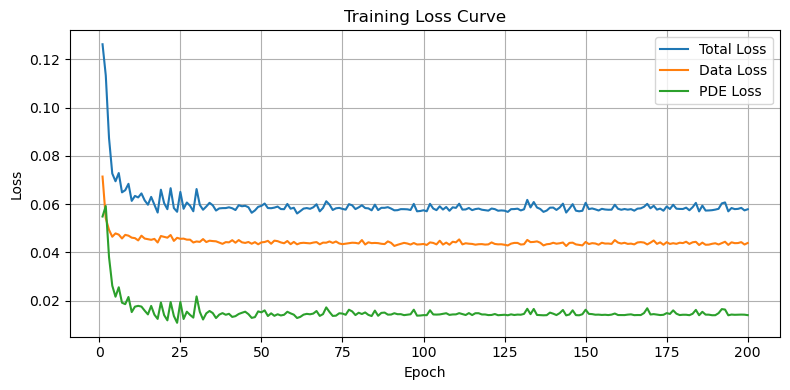

In [32]:
import matplotlib.pyplot as plt

def plot_loss_curve(loss_history,save_path=None):
    epochs = np.arange(1, len(loss_history['total']) + 1)
    plt.figure(figsize=(8, 4))
    plt.plot(epochs, loss_history['total'], label='Total Loss')
    plt.plot(epochs, loss_history['data'], label='Data Loss')
    plt.plot(epochs, loss_history['pde'], label='PDE Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"✅ Loss curve saved to {save_path}")
    plt.show()
plot_loss_curve(loss_history, save_path='./viz/loss_curve.png')

### 7.2 基于尺寸参数的反演误差热图

在本节中，我们通过二维直方图统计 $(w\_t, , l\_t)$ 平面上不同真实结构尺寸下模型的预测误差，并使用高斯模糊（Gaussian Filter）进行平滑处理，生成误差分布的热图。

该图能够展示不同尺寸组合区域的预测偏差强弱，从而直观评估模型在不同结构尺度下的稳定性和泛化能力。

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter

def plot_error_heatmap(model, dataloader, scalers, device='cpu', inverse=False, bins=40, sigma=1.0, save_path=None):
    model.eval()
    all_true, all_pred = [], []

    with torch.no_grad():
        for batch in dataloader:
            X = batch['X'].to(device)
            Y_true = batch['Y_target'].cpu().numpy()
            Y_pred = model(X).cpu().numpy()
            all_true.append(Y_true)
            all_pred.append(Y_pred)

    true_all = np.concatenate(all_true, axis=0)
    pred_all = np.concatenate(all_pred, axis=0)

    if inverse:
        true_wt = scalers['wt'].inverse_transform(true_all[:, 0].reshape(-1, 1)).flatten()
        true_lt = scalers['lt'].inverse_transform(true_all[:, 1].reshape(-1, 1)).flatten()
        pred_wt = scalers['wt'].inverse_transform(pred_all[:, 0].reshape(-1, 1)).flatten()
        pred_lt = scalers['lt'].inverse_transform(pred_all[:, 1].reshape(-1, 1)).flatten()
    else:
        true_wt, true_lt = true_all[:, 0], true_all[:, 1]
        pred_wt, pred_lt = pred_all[:, 0], pred_all[:, 1]

    # 计算总误差（欧几里得）
    error = np.sqrt((pred_wt - true_wt)**2 + (pred_lt - true_lt)**2)

    # 构建误差分布网格
    heatmap, xedges, yedges = np.histogram2d(true_wt, true_lt, bins=bins, weights=error)
    counts, _, _ = np.histogram2d(true_wt, true_lt, bins=[xedges, yedges])
    avg_error = np.divide(heatmap, counts, out=np.zeros_like(heatmap), where=counts > 0)

    # 模糊处理
    smoothed_error = gaussian_filter(avg_error.T, sigma=sigma)

    # 绘图
    plt.figure(figsize=(7, 5))
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    plt.imshow(smoothed_error, extent=extent, aspect='auto', origin='lower', cmap='magma_r')
    plt.colorbar(label='Smoothed Error')
    plt.xlabel('True w_t')
    plt.ylabel('True l_t')
    plt.title('Smoothed Error Heatmap (w_t & l_t)')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"✅ Heatmap saved to {save_path}")
    plt.show()
plot_error_heatmap(model, test_loader, scalers, device='cpu', bins=40, sigma=1.2, save_path='./viz/error_heatmap.png')


### 7.3 三维预测误差曲面图与等高线分布

本节展示了 $(w\_t, l\_t)$ 尺寸组合空间中的反演误差分布，其方式为：

* **构建三维曲面图**；
* **叠加预测点的误差分布**；
* **绘制底部等高线轮廓**。

该图有助于从全局视角观察预测误差在尺寸空间中的连续变化趋势，适用于模型精度和区域鲁棒性分析。

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from matplotlib.ticker import FuncFormatter
import numpy as np

def plot_3d_error_surface(model, dataloader, scalers, device='cpu', inverse=True, grid_res=100, save_path=None):
    model.eval()
    all_true, all_pred = [], []

    with torch.no_grad():
        for batch in dataloader:
            X = batch['X'].to(device)
            Y_true = batch['Y_target'].cpu().numpy()
            Y_pred = model(X).cpu().numpy()
            all_true.append(Y_true)
            all_pred.append(Y_pred)

    true_all = np.concatenate(all_true, axis=0)
    pred_all = np.concatenate(all_pred, axis=0)

    if inverse:
        true_wt = scalers['wt'].inverse_transform(true_all[:, 0].reshape(-1, 1)).flatten()
        true_lt = scalers['lt'].inverse_transform(true_all[:, 1].reshape(-1, 1)).flatten()
        pred_wt = scalers['wt'].inverse_transform(pred_all[:, 0].reshape(-1, 1)).flatten()
        pred_lt = scalers['lt'].inverse_transform(pred_all[:, 1].reshape(-1, 1)).flatten()

        # 转为微米单位
        true_wt *= 1e6
        true_lt *= 1e6
        pred_wt *= 1e6
        pred_lt *= 1e6
    else:
        true_wt, true_lt = true_all[:, 0], true_all[:, 1]
        pred_wt, pred_lt = pred_all[:, 0], pred_all[:, 1]


    # 欧几里得误差（单位也为 μm）
    error = np.sqrt((pred_wt - true_wt)**2 + (pred_lt - true_lt)**2)  # 转为微米单位

    # 插值网格
    wt_lin = np.linspace(min(true_wt), max(true_wt), grid_res)
    lt_lin = np.linspace(min(true_lt), max(true_lt), grid_res)
    WT_grid, LT_grid = np.meshgrid(wt_lin, lt_lin)
    ERR_grid = griddata(
        points=np.vstack((true_wt, true_lt)).T,
        values=error,
        xi=(WT_grid, LT_grid),
        method='cubic'
    )

    # 绘图
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')

    # 绘制表面 + 等高线
    surf = ax.plot_surface(WT_grid, LT_grid, np.nan_to_num(ERR_grid), cmap='magma_r', alpha=0.6)
    ax.contour(WT_grid, LT_grid, np.nan_to_num(ERR_grid), offset=0, cmap='magma_r')

    # 误差点
    ax.scatter(true_wt, true_lt, error, c=error, cmap='magma_r', edgecolor='k', s=5, alpha=0.7, label='Error')

    # 轴设置
    ax.set_xlabel('True w_t (μm)')
    ax.set_ylabel('True l_t (μm)')
    ax.set_zlabel('Prediction Error')
    ax.set_title('3D Error Surface + Contour (w_t vs l_t)')
    ax.set_xlim(true_wt.min(), true_wt.max())
    ax.set_ylim(true_lt.min(), true_lt.max())
    ax.set_zlim(0, error.max() * 1.05)

    # 科学计数法 Z 轴
    #ax.zaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1e}'))
    # 色条
    cb = fig.colorbar(surf, ax=ax, pad=0.1, shrink=0.6, aspect=15)
    cb.set_label('Prediction Error (m)')

    ax.view_init(elev=30, azim=130)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"✅ Saved 3D error plot to {save_path}")

    plt.show()

plot_3d_error_surface(model, test_loader, scalers, device='cpu', save_path='./viz/3d_error_plot.png')


### 7.4 结构尺寸反演向量场图（采样 160 点）

为了可视化模型在尺寸反演任务中的预测行为，我们绘制了反演向量场图。图中：

* 每个箭头表示一个样本 $(w\_t, l\_t)$ 的反演偏移；
* 箭头起点为真实值，终点为预测值；
* 使用 **20% 相对误差阈值** 标记预测偏移较大的样本为红色；
* 其他预测为灰色；
* 所有坐标单位为微米 $(\mu\text{m})$。

#### 样本选择策略

由于样本点较多，为避免图像拥挤，我们采用了等宽 bin 分布采样方式：

* 将真实 $w\_t$ 范围划分为 `160` 个等间隔 bin；
* 每个 bin 内选取一个代表样本进行展示。

#### 数学定义说明

误差矢量定义为：

$$
\vec{e}_i = \left( \hat{w}_t^{(i)} - w_t^{(i)},\; \hat{l}_t^{(i)} - l_t^{(i)} \right)
$$

相对误差判断条件为：

$$
\left| \frac{\hat{w}_t^{(i)} - w_t^{(i)}}{w_t^{(i)}} \right| > 0.2 \quad \text{or} \quad \left| \frac{\hat{l}_t^{(i)} - l_t^{(i)}}{l_t^{(i)}} \right| > 0.2
$$

满足条件的样本在图中以红色箭头表示，表示结构尺寸预测偏离较大。

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_inverse_vector_field_sampled(model, dataloader, scalers, device='cpu',
                                      inverse=True, max_points=160,
                                      save_path=None):
    model.eval()
    all_true, all_pred = [], []

    with torch.no_grad():
        for batch in dataloader:
            X = batch['X'].to(device)
            Y_true = batch['Y_target'].cpu().numpy()
            Y_pred = model(X).cpu().numpy()
            all_true.append(Y_true)
            all_pred.append(Y_pred)

    true_all = np.concatenate(all_true, axis=0)
    pred_all = np.concatenate(all_pred, axis=0)

    # 返归一化
    if inverse:
        true_wt = scalers['wt'].inverse_transform(true_all[:, 0].reshape(-1, 1)).flatten()
        true_lt = scalers['lt'].inverse_transform(true_all[:, 1].reshape(-1, 1)).flatten()
        pred_wt = scalers['wt'].inverse_transform(pred_all[:, 0].reshape(-1, 1)).flatten()
        pred_lt = scalers['lt'].inverse_transform(pred_all[:, 1].reshape(-1, 1)).flatten()
        # 转为 μm
        true_wt *= 1e6
        true_lt *= 1e6
        pred_wt *= 1e6
        pred_lt *= 1e6
    else:
        true_wt, true_lt = true_all[:, 0], true_all[:, 1]
        pred_wt, pred_lt = pred_all[:, 0], pred_all[:, 1]



    # 按照 true_wt 分成 max_points 个 bin，每个 bin 选一个代表样本
    bins = np.linspace(true_wt.min(), true_wt.max(), max_points + 1)
    sampled_idx = []

    for i in range(len(bins) - 1):
        mask = (true_wt >= bins[i]) & (true_wt < bins[i + 1])
        if np.any(mask):
            idx = np.where(mask)[0][0]  # 取第一个样本
            sampled_idx.append(idx)

    sampled_idx = np.array(sampled_idx)
    tw, tl = true_wt[sampled_idx], true_lt[sampled_idx]
    pw, pl = pred_wt[sampled_idx], pred_lt[sampled_idx]

    # 差值
    u = pw - tw
    v = pl - tl
    error = np.sqrt(u**2 + v**2)

    # 使用比例误差判断（20% 阈值）
    err_ratio_wt = np.abs(pw - tw) / tw
    err_ratio_lt = np.abs(pl - tl) / tl
    high_error = (err_ratio_wt > 0.2) | (err_ratio_lt > 0.2)
    colors = np.where(high_error, 'red', 'gray')


    # 绘图
    plt.figure(figsize=(8, 8))
    plt.quiver(tw, tl, u, v, angles='xy', scale_units='xy', scale=1, color=colors, width=0.003)
    plt.scatter(tw, tl, c='black', s=10, label='True (Ground truth)')
    plt.scatter(pw, pl, c='blue', s=10, alpha=0.6, label='Predicted')
    plt.xlabel('w_t (μm)')
    plt.ylabel('l_t (μm)')
    plt.title('Inverse Prediction Trajectory ( 160 Sampled , 20% Threshold)')
    plt.legend()
    plt.grid(True)

    plt.xlim(5, 20)
    plt.ylim(100, 1000)

    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"✅ Saved inverse trajectory figure to {save_path}")

    plt.tight_layout()
    plt.show()
plot_inverse_vector_field_sampled(
    model,
    test_loader,
    scalers,
    device='cpu',
    max_points=160,
    save_path='./viz/inverse_arrow_sampled.png'
)


### 7.5 结构参数预测分布对比图

该图用于展示反演模型在结构参数 $w\_t$（宽度）与 $l\_t$（长度）上的预测分布与真实分布之间的拟合程度。

* 所有尺寸单位均为微米 $(\mu\text{m})$。
* 黑色线表示真实样本的参数分布；
* 蓝色区域表示模型预测的参数分布；
* 使用核密度估计（KDE）叠加直方图更直观地反映分布差异。

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_distribution_comparison(model, dataloader, scalers, device='cpu', inverse=True, save_path=None):
    model.eval()
    all_true, all_pred = [], []

    with torch.no_grad():
        for batch in dataloader:
            X = batch['X'].to(device)
            Y_true = batch['Y_target'].cpu().numpy()
            Y_pred = model(X).cpu().numpy()
            all_true.append(Y_true)
            all_pred.append(Y_pred)

    true_all = np.concatenate(all_true, axis=0)
    pred_all = np.concatenate(all_pred, axis=0)

    # 返归一化
    if inverse:
        true_wt = scalers['wt'].inverse_transform(true_all[:, 0].reshape(-1, 1)).flatten() * 1e6
        true_lt = scalers['lt'].inverse_transform(true_all[:, 1].reshape(-1, 1)).flatten() * 1e6
        pred_wt = scalers['wt'].inverse_transform(pred_all[:, 0].reshape(-1, 1)).flatten() * 1e6
        pred_lt = scalers['lt'].inverse_transform(pred_all[:, 1].reshape(-1, 1)).flatten() * 1e6
    else:
        true_wt, true_lt = true_all[:, 0], true_all[:, 1]
        pred_wt, pred_lt = pred_all[:, 0], pred_all[:, 1]

    # 绘图
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    sns.histplot(true_wt, color='black', label='True w_t', kde=True, stat='density', ax=axes[0])
    sns.histplot(pred_wt, color='blue', label='Predicted w_t', kde=True, stat='density', ax=axes[0], alpha=0.6)
    axes[0].set_title('w_t Distribution (μm)')
    axes[0].legend()

    sns.histplot(true_lt, color='black', label='True l_t', kde=True, stat='density', ax=axes[1])
    sns.histplot(pred_lt, color='blue', label='Predicted l_t', kde=True, stat='density', ax=axes[1], alpha=0.6)
    axes[1].set_title('l_t Distribution (μm)')
    axes[1].legend()

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"✅ Saved parameter distribution comparison to {save_path}")
    plt.show()
plot_distribution_comparison(
    model,
    test_loader,
    scalers,
    device='cpu',
    save_path='./viz/param_distribution_comparison.png'
)



### 7.6 三维结构反演动画（True vs Predicted）

该动画用于展示微悬梁结构的真实尺寸与模型预测尺寸之间的动态对比。

#### 可视化目标

* 微悬梁厚度 $d$ 固定为 $25 , \mu m$；
* 横坐标为预测与真实梁长 $l\_t$，纵坐标为梁宽 $w\_t$；
* 高度维度为固定厚度；
* 灰色结构为真实尺寸，彩色结构为模型预测尺寸，颜色深浅表示面积误差大小（百分比）；
* 动态展示多个样本的预测精度，并附有每帧误差信息表。

#### 数学定义

预测误差通过面积相对误差计算：

$$
\text{Error}_i = \left| \frac{w_{t, i}^\text{pred} \cdot l_{t, i}^\text{pred} - w_{t, i}^\text{true} \cdot l_{t, i}^\text{true}}{w_{t, i}^\text{true} \cdot l_{t, i}^\text{true}} \right| \times 100 \%
$$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
import torch
import os
from IPython.display import HTML
from matplotlib.colors import Normalize,PowerNorm,LogNorm
from matplotlib.cm import ScalarMappable

def extract_monotonic_samples_exhaustive(model, dataloader, scalers, device='cpu'):
    model.eval()

    wt_all, lt_all, wt_pred_all, lt_pred_all = [], [], [], []

    with torch.no_grad():
        for batch in dataloader:
            X = batch['X'].to(device)
            Y_true = batch['Y_target'].cpu().numpy()
            Y_pred = model(X).cpu().numpy()

            true_wt = scalers['wt'].inverse_transform(Y_true[:, 0].reshape(-1, 1)).flatten()
            true_lt = scalers['lt'].inverse_transform(Y_true[:, 1].reshape(-1, 1)).flatten()
            pred_wt = scalers['wt'].inverse_transform(Y_pred[:, 0].reshape(-1, 1)).flatten()
            pred_lt = scalers['lt'].inverse_transform(Y_pred[:, 1].reshape(-1, 1)).flatten()

            wt_all.extend(true_wt)
            lt_all.extend(true_lt)
            wt_pred_all.extend(pred_wt)
            lt_pred_all.extend(pred_lt)

    all_samples = list(zip(wt_all, lt_all, wt_pred_all, lt_pred_all))
    all_samples_sorted = sorted(set(all_samples), key=lambda x: (x[0], x[1]))

    # 提取最大值作为终止判断
    max_wt = max(wt_all)
    max_lt = max(lt_all)
    selected = []
    last_wt, last_lt = -np.inf, -np.inf

    for w, l, wp, lp in all_samples_sorted:
        # 已到达最大值时，跳出
        if np.isclose(last_wt, max_wt) and np.isclose(last_lt, max_lt):
            break

        # 双递增阶段
        if last_wt < max_wt and last_lt < max_lt:
            if w > last_wt and l > last_lt:
                selected.append((w, l, wp, lp))
                last_wt, last_lt = w, l

        # 仅允许 lt 增加（wt 已到最大）
        elif np.isclose(last_wt, max_wt) and last_lt < max_lt:
            if np.isclose(w, last_wt) and l > last_lt:
                selected.append((w, l, wp, lp))
                last_wt, last_lt = w, l

        # 仅允许 wt 增加（lt 已到最大）
        elif np.isclose(last_lt, max_lt) and last_wt < max_wt:
            if w > last_wt and np.isclose(l, last_lt):
                selected.append((w, l, wp, lp))
                last_wt, last_lt = w, l

    if len(selected) == 0:
        raise ValueError("❌ 没有找到可递增采样数据")

    wt_list, lt_list, wt_pred_list, lt_pred_list = zip(*selected)
    return list(wt_list), list(lt_list), list(wt_pred_list), list(lt_pred_list)



def create_beam_animation(wt, lt, wt_pred, lt_pred,
                          d_fixed=26e-6,
                          save_gif_path=None,
                          show=True):


    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111, projection='3d')

    max_w = max(max(wt), max(wt_pred)) * 1.1
    max_l = max(max(lt), max(lt_pred)) * 1.1

    # 误差计算
    wt = np.array(wt)
    lt = np.array(lt)
    wt_pred = np.array(wt_pred)
    lt_pred = np.array(lt_pred)

    area_true = wt * lt
    area_pred = wt_pred * lt_pred
    error = (np.abs(area_pred - area_true) / area_true) * 100  # 单位：%


    cmap = plt.get_cmap('Spectral')
    #norm = Normalize(vmin=error.min(), vmax=error.max())
    #norm = PowerNorm(gamma=0.5, vmin=error.min(), vmax=error.max())
    norm = LogNorm(vmin=error.min(), vmax=error.max())  # 避免 vmin=0 错误
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    def plot_beam(ax, w, l, d, color='gray', alpha=1.0):
        y = [0, w, w, 0, 0]
        x = [0, 0, l, l, 0] 
        z = [0] * 5
        ax.plot3D(x, y, z, color=color, alpha=alpha)
        ax.plot3D(x, y, [d] * 5, color=color, alpha=alpha)
        for i in range(4):
            ax.plot3D([x[i], x[i]], [y[i], y[i]], [0, d], color=color, alpha=alpha)

    def update(i):
        ax.cla()
        ax.set_ylim(0, max_w * 1e6)
        ax.set_xlim(0, max_l * 1e6)
        ax.set_ylabel('Width (μm)')
        ax.set_xlabel('Length (μm)')
        ax.set_zlim(0, d_fixed * 1e6)
        ax.set_zlabel('Thickness (μm)')
        # ax.set_box_aspect([10, 2, 2.5])  # x:lt, y:wt, z:thickness
        # 添加动态视角旋转
        # azim = 45 + i * 1.5
        # elev = 20 + 10 * np.sin(np.radians(i * 2))
        # ax.view_init(elev=elev, azim=azim)  
        w_t = wt[i] * 1e6
        l_t = lt[i] * 1e6
        w_tp = wt_pred[i] * 1e6
        l_tp = lt_pred[i] * 1e6
        thick = d_fixed * 1e6
        ax.set_title(
            f"Sample {i+1} | Error = {error[i]:.1f}%\n"
            f"{'Parameter':<10} {'True':>8}    {'Pred':>8}\n"
            f"{'wt (μm)':<10} {w_t:>8.1f}  {w_tp:>8.1f}\n"
            f"{'lt (μm)':<10} {l_t:>8.1f} {l_tp:>8.1f}",
        )

        # 绘制梁
        plot_beam(ax, wt[i]*1e6, lt[i]*1e6, d_fixed*1e6, color='gray', alpha=0.8)
        color_pred = cmap(error[i])
        plot_beam(ax, wt_pred[i]*1e6, lt_pred[i]*1e6, d_fixed*1e6, color=color_pred, alpha=0.8)


    ani = animation.FuncAnimation(fig, update, frames=len(wt), interval=200)
    # 添加色条
    fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.05, pad=0.05, label='Area Error (%)')
    if save_gif_path:
        ani.save(save_gif_path, writer='pillow', fps=15,dpi=300)
        #ani.save(save_gif_path, writer='pillow', fps=10, dpi=100, savefig_kwargs={'bbox_inches': 'tight'})
        print(f"✅ Saved animation to: {save_gif_path}")

    if show:
        from IPython.display import display, HTML


        display(HTML(ani.to_jshtml()))

    plt.close()




wt_list, lt_list, wt_pred_list, lt_pred_list = extract_monotonic_samples_exhaustive(
    model, test_loader, scalers, device='cpu'
)


HTML_obj =create_beam_animation(
    wt_list, lt_list, wt_pred_list, lt_pred_list,
    d_fixed=25e-6,save_gif_path='./viz/beam_animation.gif', show=True
)


### 7.7 三维结构旋转动画（以器件为视角聚焦）

该部分展示一个动态旋转动画，用于突出结构预测结果的**几何对比**效果。不同于前一节以坐标系为参考的静态可视化，这里我们采用**以器件为中心、旋转视角动态聚焦**的动画风格，突出不同结构尺寸的空间形态变化。

#### 特点说明

* 灰色梁：真实尺寸；
* 彩色梁：模型预测结果，颜色代表面积预测误差百分比（色图：Spectral + 对数归一）；
* 自动缩放：每帧自适应设置视角和边界以保持梁结构聚焦；
* 旋转视角：绕对角线方向缓慢转动，提供多角度三维感知；
* 单位统一：$\mu m$；
* 坐标轴隐藏，强调器件本体视觉；
* 标题中同时展示预测误差及对应参数的真实与预测值。



In [ ]:
def create_beam_object_focus_animation(wt, lt, wt_pred, lt_pred,
                                       d_fixed=26e-6,
                                       save_gif_path=None,
                                       show=True):
    import matplotlib.pyplot as plt
    from matplotlib import animation
    from matplotlib.colors import LogNorm
    from matplotlib.cm import ScalarMappable
    import numpy as np

    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111, projection='3d')

    wt = np.array(wt)
    lt = np.array(lt)
    wt_pred = np.array(wt_pred)
    lt_pred = np.array(lt_pred)

    area_true = wt * lt
    area_pred = wt_pred * lt_pred
    error = (np.abs(area_pred - area_true) / area_true) * 100  # %

    cmap = plt.get_cmap('Spectral')
    norm = LogNorm(vmin=error.min(), vmax=error.max())
    sm = ScalarMappable(cmap=cmap, norm=norm)

    def plot_beam(ax, w, l, d, color='gray', alpha=1.0):
        y = [0, w, w, 0, 0]
        x = [0, 0, l, l, 0]
        z = [0] * 5
        ax.plot3D(x, y, z, color=color, alpha=alpha)
        ax.plot3D(x, y, [d] * 5, color=color, alpha=alpha)
        for i in range(4):
            ax.plot3D([x[i], x[i]], [y[i], y[i]], [0, d], color=color, alpha=alpha)

    def update(i):
        ax.cla()
        w_t = wt[i] * 1e6
        l_t = lt[i] * 1e6
        w_tp = wt_pred[i] * 1e6
        l_tp = lt_pred[i] * 1e6
        thick = d_fixed * 1e6

        # 设置视角区域聚焦梁本体
        margin = 0.2
        ax.set_xlim(0, max(l_t, l_tp) * (1 + margin))
        ax.set_ylim(0, max(w_t, w_tp) * (1 + margin))
        ax.set_zlim(0, thick * (1 + margin))
        #ax.set_box_aspect([1, 1, 0.2])
        #ax.set_xlim(0, 500)
        #ax.set_ylim(0, 10)
        #ax.set_zlim(0, 12.5)
        ax.set_box_aspect([100, 2, 2.5])  # x:lt, y:wt, z:thickness
        # 关闭轴
        ax.set_axis_off()
        # # 添加动态视角旋转
        azim = 45 + i * 1.5
        elev = 20 + 10 * np.sin(np.radians(i * 2))
        ax.view_init(elev=elev, azim=azim)
        # 添加 title
        ax.set_title(
            f"Sample {i+1} | Error = {error[i]:.1f}%\n"
            f"{'Parameter':<10} {'True':>8}    {'Pred':>8}\n"
            f"{'wt (μm)':<10} {w_t:>8.1f}  {w_tp:>8.1f}\n"
            f"{'lt (μm)':<10} {l_t:>8.1f} {l_tp:>8.1f}",
        )


        # 绘图
        plot_beam(ax, w_t, l_t, thick, color='gray', alpha=0.8)
        color_pred = cmap(norm(error[i]))
        plot_beam(ax, w_tp, l_tp, thick, color=color_pred, alpha=0.9)

    ani = animation.FuncAnimation(fig, update, frames=len(wt), interval=200)

    if save_gif_path:
        ani.save(save_gif_path, writer='pillow', fps=15,dpi = 200)
        print(f"✅ Saved animation to: {save_gif_path}")

    if show:
        from IPython.display import HTML, display
        display(HTML(ani.to_jshtml()))

    plt.close()


create_beam_object_focus_animation(
    wt_list, lt_list, wt_pred_list, lt_pred_list,
    d_fixed=25e-6,
    show=True,
    save_gif_path='./viz/beam_object_focus_animation_rotate.gif'
)
